### References:
parts of this code was inspired by the code provided by bernt for class exercises 8 "ZI and Learners" , 10 "Profit sharing and deeper models that can handle non-stationarity"  and the youtube channels :  "Nicolai Nielsen - Computer Vision & AI" , "sentdex" and "Neuromatch Academy"

### Imports

In [48]:
import numpy as np
import matplotlib.pyplot as plt

### Instruction of our GridWorld - what happens when you reach the goal, hit a wall, visit a trap

In [49]:
class Grid():
    def __init__(self):
        self.n_states = 100
        self.n_actions = 4

    def get_outcome(self, state, action):
        if state == 49:  # goal state
            reward = 0
            next_state = None
            return next_state, reward
        reward = -5  # default reward value
        
        if action == 0:  # move right
            next_state = state + 1
            if state == 48:  # next state is goal state
                reward = 1000
            elif state % 10 == 9:  # right border
                next_state = state
            elif state in [60,70,45,35,56,66]:  # next state is wall
                next_state = state
            elif state in [97,15]:  # next state is trap
                if state == 15:
                    reward= -100
                if state == 97:
                    reward= -500
                    
        elif action == 1:  # move up
            next_state = state + 10
            if state == 39:  # next state is goal state
                reward = 1000
            if state >= 90 or state in [41,42,26,27]:  # top border or wall
                next_state = state
            elif state in [88,6]:  # next state is trap
                if state == 6:
                    reward= -100
                if state == 88:
                    reward= -500
        
        elif action == 2:  # move left
            next_state = state - 1
            if state % 10 == 0 or state in [53,63,68,58,48,38] :  # left border
                next_state = state
            elif state in [17,99]:  # next state is trap
                if state == 17:
                    reward= -100
                if state == 99:
                    reward= -500
                
        elif action == 3:  # move down
            next_state = state - 10
            if state == 59:  # next state is goal state
                reward = 1000
            if state <= 9 or state in [71,72,56,77]:  # bottom border
                next_state = state
            elif state == 26:  # next state is trap
                reward= -100
        else:
            print("Action must be between 0 and 3.")
            next_state = None
            reward = None
        return int(next_state) if next_state is not None else None, reward

### Epsilon Greedy Policy for balancing exploration vs explotaion while choosing an action

In [50]:
def epsilon_greedy(q, epsilon):
    if np.random.random() > epsilon:
        action = np.argmax(q)
    else:
        action = np.random.choice(len(q))

    return action


## Model-free:
### Q-learning and it's helper function

In [51]:
    
""" 
Tuning[0] epsilon  # epsilon-greedy policy
Tuning[1] gamma   # temporal discount factor
Tuning[2] alpha  # learning rate
Tuning[3] planning_steps ,  # number of Dyna-Q planning steps
"""

def q_learning(state, action, reward, next_state, Qvalues, tuning):
    
    #value of previous state-action pair
    q = Qvalues[int(state), int(action)]

    #The MAX element is an exploiter - greedy
    qVal = Qmax(Qvalues, next_state)
     
    # update value of previous state-action pair based on Temporal Difference algorithm
    Qvalues[int(state), int(action)] = q + tuning[2] * (reward + tuning[1] * qVal - q)

    return Qvalues


def Qmax(Qvalues, next_state):

    if next_state is None or np.isnan(next_state):
        qVal = 0
    else:
        qVal = np.max(Qvalues[int(next_state)])
  
    return qVal


## Model-based :
### Dyna-Q learning function

In [52]:

def dynamic_q_planner(model, Qvalues, tuning, reward, next_state, state, action):
    #The algorithm is shown in Fig 5. in the report
  
    # Model(S;A) <-  (R; S) (assuming deterministic environment)
    model[state, action] = reward, next_state

    for i in range(tuning[3]):
        #get all the visited states
        visited = np.array(np.where(~np.isnan(model[:,:,0]))).T
        # choose a random one
        idx = np.random.choice(len(visited))
        #update the Qtable with the randomly selected state
        state, action = visited[idx]
        reward, next_state = model[state, action]
        Qvalues = q_learning(state, action, reward, next_state, Qvalues, tuning)

    return Qvalues,model


### learn enviroment sets up and calls all the neccesary functions in order

In [69]:
""" 
Tuning[0] epsilon # epsilon-greedy policy
Tuning[1] gamma  # temporal discount factor
Tuning[2] alpha  # learning rate
Tuning[3] planning_steps # number of Dyna-Q planning steps
"""
def learn_environment(GridWorld,n_episodes,max_steps,tuning):

    #initializing empty tables to start training
    Qvalues = np.ones((GridWorld.n_states, GridWorld.n_actions))
    reward_sums = np.zeros(n_episodes)
    episode_steps = np.zeros(n_episodes)
    model = np.nan*np.zeros((GridWorld.n_states, GridWorld.n_actions, 2))

    for episode in range(n_episodes): 
        state = 90 
        reward_sum = 0
        i=0
        for i in range(max_steps):
            # take an action based on epsilon greedy policy
            action = epsilon_greedy(Qvalues[state], tuning[0])
            # check what is the reward and outcome of taking the action in state
            next_state, reward = GridWorld.get_outcome(state, action)
            reward_sum += reward
            #update the Qtable based on the new action and reward
            Qvalues = q_learning(state, action, reward, next_state, Qvalues, tuning)
            # Dyna Q algorithm - will not run in case of we have set tuning[3] to zero
            Qvalues, model = dynamic_q_planner(model, Qvalues, tuning, reward, next_state, state, action)
            
            #for the times where we reach the goal and want to stop the algorithm
            if next_state is None:
                break  
            state = next_state

        reward_sums[episode] = reward_sum
        episode_steps[episode] = i+1

    return Qvalues, reward_sums, episode_steps

### Plots

In [54]:

from scipy.signal import convolve as conv


def plot_quiver_max_action(env, value, ax=None):
    dim=10
    if ax is None:
        fig, ax = plt.subplots()
    dim=10
    X = np.tile(np.arange(dim), [dim,1]) + 0.5
    Y = np.tile(np.arange(dim)[::-1][:,np.newaxis], [1,dim]) + 0.5
    which_max = np.reshape(value.argmax(axis=1), (dim,dim))
    which_max = which_max[::-1,:]
    U = np.zeros(X.shape)
    V = np.zeros(X.shape)
    U[which_max == 0] = 1
    V[which_max == 1] = 1
    U[which_max == 2] = -1
    V[which_max == 3] = -1

    ax.quiver(X, Y, U, V)
    ax.set(
      title='Maximum value/probability actions',
      xlim=[-0.5, dim +0.5],
      ylim=[-0.5, dim +0.5],
    )
    ax.set_xticks(np.linspace(0.5, dim - 0.5, num=dim))
    ax.set_xticklabels(["%d" % x for x in np.arange(dim)])
    ax.set_xticks(np.arange(dim +1), minor=True)
    ax.set_yticks(np.linspace(0.5, dim-0.5, num=dim))
    ax.set_yticklabels(["%d" % y for y in np.arange(0, dim*dim,
                                                  dim)])
    ax.set_yticks(np.arange(dim+1), minor=True)
    ax.grid(which='minor',linestyle='-')

def plot_heatmap_max_val(env, value, ax=None):
    dim=10
    if ax is None:
        fig, ax = plt.subplots()

    if value.ndim == 1:
        value_max = np.reshape(value, (dim,dim))
    else:
        value_max = np.reshape(value.max(axis=1), (dim,dim))
    value_max = value_max[::-1,:]

    im = ax.imshow(value_max, aspect='auto', interpolation='none', cmap='afmhot')
    ax.set(title='Maximum value per state')
    ax.set_xticks(np.linspace(0, dim-1, num=dim))
    ax.set_xticklabels(["%d" % x for x in np.arange(dim)])
    ax.set_yticks(np.linspace(0, dim-1, num=dim))
    ax.set_yticklabels(["%d" % y for y in np.arange(
            0, dim*dim, dim)][::-1])
    return im

def plot_rewards(n_episodes, rewards, average_range=10, ax=None):
    dim=10
    if ax is None:
        fig, ax = plt.subplots()

    smoothed_rewards = (conv(rewards, np.ones(average_range), mode='same')
                      / average_range)

    ax.plot(range(0, n_episodes, average_range),
          smoothed_rewards[0:n_episodes:average_range],
          marker='o', linestyle='--')
    ax.set(xlabel='Episodes', ylabel='Total reward')


def plot_performance(env, value, reward_sums,n_episodes):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
    plot_quiver_max_action(env, value, ax=axes[0,1])
    plot_rewards(n_episodes, reward_sums, ax=axes[1,0])
    im = plot_heatmap_max_val(env, value, ax=axes[1,1])
    fig.colorbar(im)



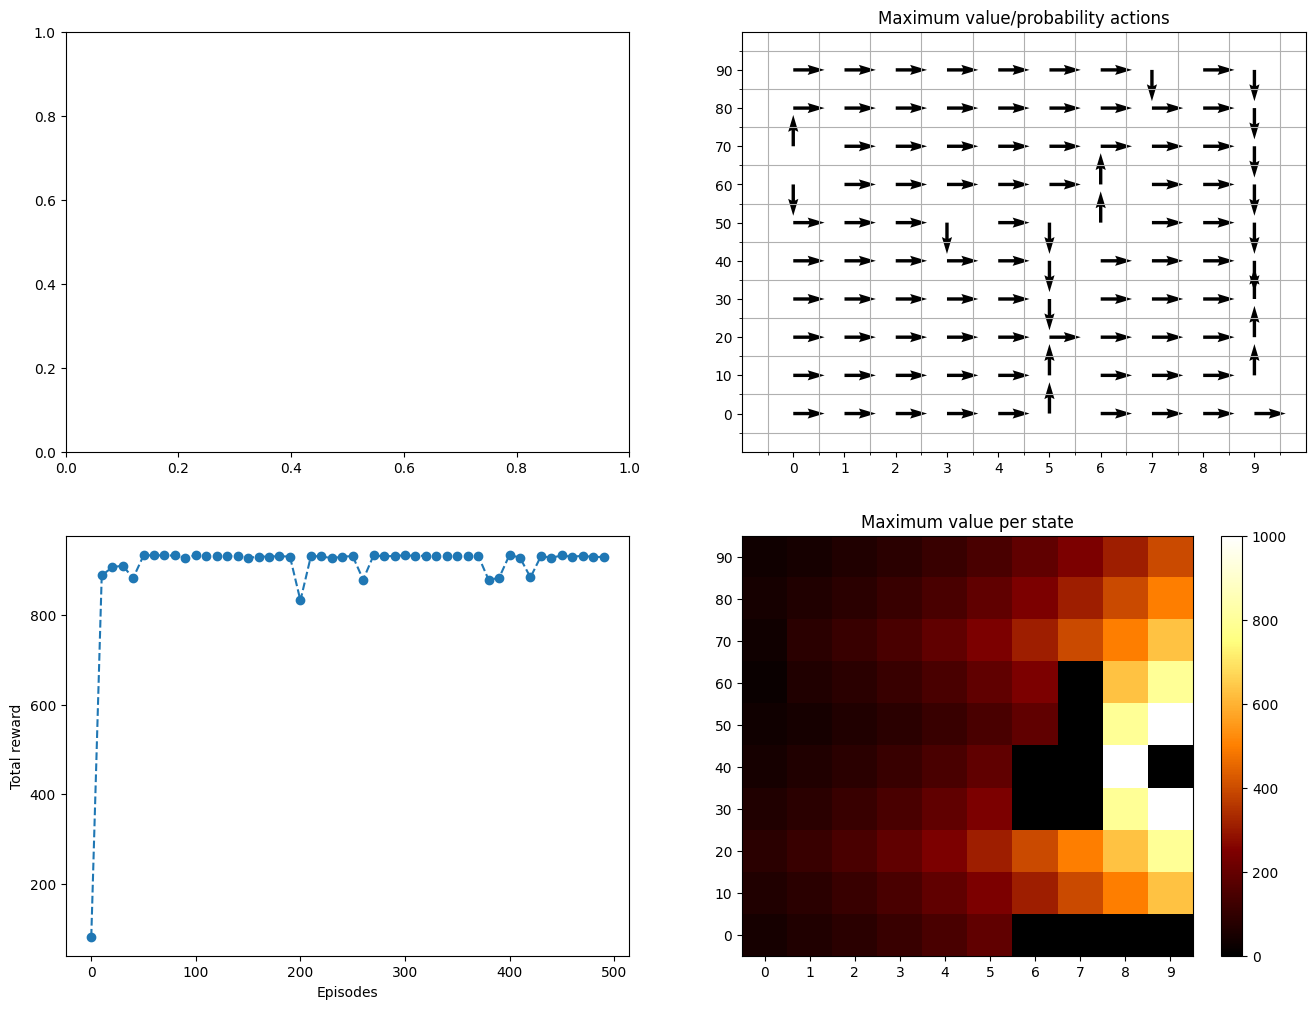

In [55]:

# set for reproducibility, comment out / change seed value for different results
np.random.seed(1)

""" 
Tuning[0] epsilon = 0.05  # epsilon-greedy policy
Tuning[1] gamma = 0.8    # temporal discount factor
Tuning[2] alpha = 0.5  # learning rate
Tuning[3] planning_steps = 10,  # number of Dyna-Q planning steps

"""
tuning = [0.05, 0.8, 0.5, 10]

GridWorld = Grid()
"""
number of episodes = 500
maximum steps= 1000
"""
n_episodes = 500
results = learn_environment(GridWorld,n_episodes,1000,tuning)
Qvalues, reward_sum,episode_steps= results

## Plot the results

plot_performance(GridWorld, Qvalues, reward_sum,n_episodes)

# Result For Q-learning
### setting planning steps to zero means that there is no planning step and no model, so the algorithm switches to Q-learning

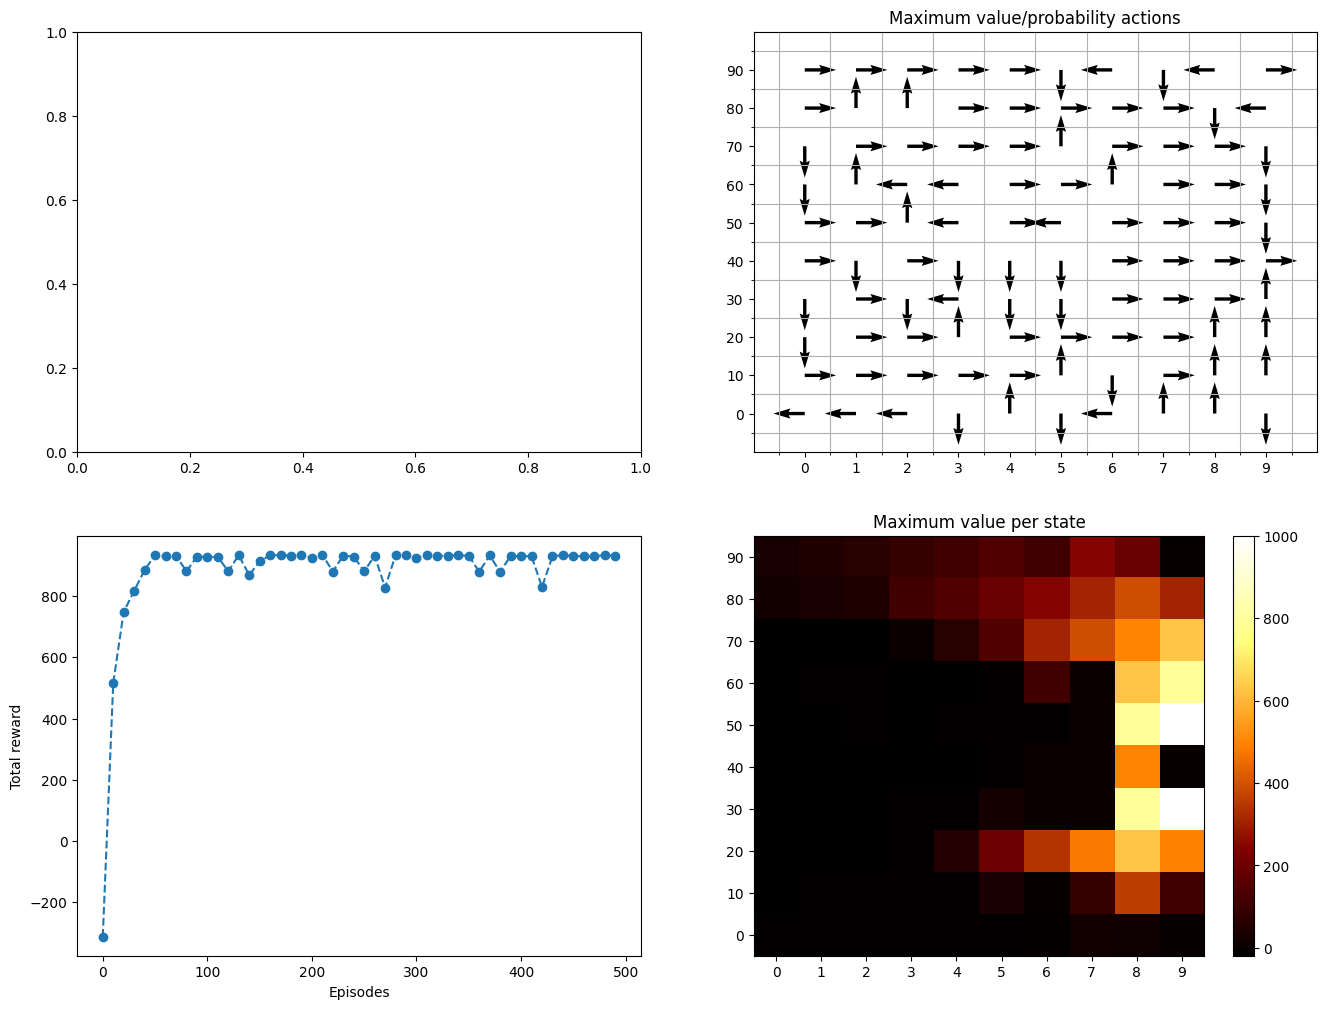

In [56]:

# set for reproducibility, comment out / change seed value for different results
np.random.seed(1)

""" 
Tuning[0] epsilon = 0.05  # epsilon-greedy policy
Tuning[1] gamma = 0.8    # temporal discount factor
Tuning[2] alpha = 0.5  # learning rate
Tuning[3] planning_steps = 0,  # number of Dyna-Q planning steps

"""
tuning = [0.05, 0.8, 0.5, 0]

GridWorld = Grid()
"""
number of episodes = 500
maximum steps= 1000
"""
n_episodes = 500
results = learn_environment(GridWorld,n_episodes,1000,tuning)
Qvalues, reward_sum,episode_steps= results

## Plot the results

plot_performance(GridWorld, Qvalues, reward_sum,n_episodes)

## Comparing Q-learning and Dyna-Q with different planning steps

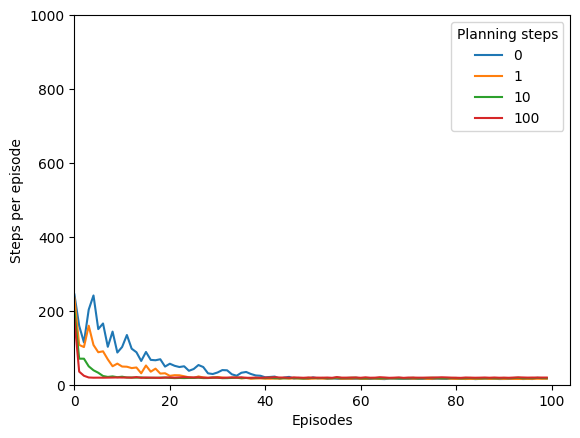

In [66]:
np.random.seed(1)


""" 
Tuning[0] epsilon = 0.05  # epsilon-greedy policy
Tuning[1] gamma = 0.8    # temporal discount factor
Tuning[2] alpha = 0.5  # learning rate
Tuning[3] planning_steps = 0,  # number of Dyna-Q planning steps

"""
tuning = [0.05, 0.8, 0.5, 0]

# episodes/trials
n_experiments = 10
n_episodes = 100
max_steps = 1000

# number of planning steps
planning_steps = np.array([0,1, 10,100])

# environment initialization
env = Grid()

steps_per_episode = np.zeros((len(planning_steps), n_experiments, n_episodes))

for i, k in enumerate(planning_steps):
    tuning[3] = k
    for experiment in range(n_experiments):
        results = learn_environment(env,n_episodes, max_steps, tuning) 
        steps_per_episode[i, experiment] = results[2]

# Average across experiments
steps_per_episode = np.mean(steps_per_episode, axis=1)

# Plot results
fig, ax = plt.subplots()
ax.plot(steps_per_episode.T)
ax.set(xlabel='Episodes', ylabel='Steps per episode',
       xlim=[0, None], ylim=[0, 1000])
ax.legend(planning_steps, loc='upper right', title="Planning steps");



# Bounty Hunter

In [60]:
class BountyHunterGrid():
    def __init__(self):
        self.n_states = 100
        self.n_actions = 5

    def get_outcome(self, state, action):
        F2=False
        if np.random.random() >= 0.35:
            F2=True

        if F2==False and state == 38:  # goal state
            reward = 0
            next_state = None
            return next_state, reward
        elif F2 and state==42:
            reward = 0
            next_state = None
            return next_state, reward
        
        reward = -5  # default reward value

        if action == 0:  # move right
            next_state = state + 1
            if F2 and state==41:
                reward = 1000
            if state % 10 == 9:  # right border
                next_state = state
            elif state in [60,70,45,35,56,66]:  # next state is wall
                next_state = state
            elif state in [97,15]:  # next state is trap
                if state == 15:
                    reward= -100
                if state == 97:
                    reward= -500

        elif action == 1:  # move up
            next_state = state + 10
            if F2==False and state == 28:  # next state is goal state
                reward = 1000
            if F2 and state==31:
                reward = 1000
            if state >= 90 or state in [41,42,26,27]:  # top border or wall
                next_state = state
            elif state in [88,6]:  # next state is trap
                if state == 6:
                    reward= -100
                if state == 88:
                    reward= -500

        elif action == 2:  # move left
            next_state = state - 1
            if F2==False and state == 39:  # next state is goal state
                reward = 1000
            if F2 and state==43:
                reward = 1000
            if state % 10 == 0 or state in [53,63,68,58,48,38] :  # left border
                next_state = state
            elif state in [17,99]:  # next state is trap
                if state == 17:
                    reward= -100
                if state == 99:
                    reward= -500

        elif action == 3:  # move down
            next_state = state - 10
            if F2==False and state == 48:  # next state is goal state
                reward = 1000
            if state <= 9 or state in [71,72,56,77]:  # bottom border
                next_state = state
            elif state == 26:  # next state is trap
                reward= -100
        elif action == 4:  # wait
            next_state = state
        else:
            print("Action must be between 0 and 3.")
            next_state = None
            reward = None
        return int(next_state) if next_state is not None else None, reward

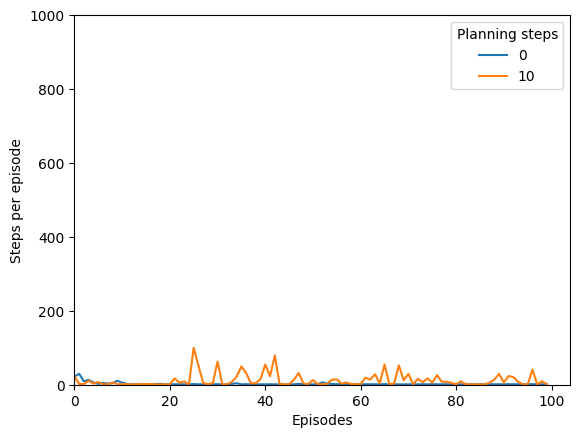

In [70]:
np.random.seed(1)


""" 
Tuning[0] epsilon = 0.05  # epsilon-greedy policy
Tuning[1] gamma = 0.8    # temporal discount factor
Tuning[2] alpha = 0.5  # learning rate
Tuning[3] planning_steps = 0,  # number of Dyna-Q planning steps

"""
tuning = [0.05, 0.8, 0.5, 0]

# episodes/trials
n_episodes = 100
max_steps = 1000

# number of planning steps
planning_steps = np.array([0,10])

# environment initialization
env = BountyHunterGrid()

steps_per_episode = np.zeros((len(planning_steps), n_experiments, n_episodes))

for i, k in enumerate(planning_steps):
    tuning[3] = k
    results = learn_environment(env,n_episodes, max_steps, tuning) 
    steps_per_episode[i, experiment] = results[2]

# Average across experiments
steps_per_episode = np.mean(steps_per_episode, axis=1)

# Plot results
fig, ax = plt.subplots()
ax.plot(steps_per_episode.T)
ax.set(xlabel='Episodes', ylabel='Steps per episode',
       xlim=[0, None], ylim=[0, 1000])
ax.legend(planning_steps, loc='upper right', title="Planning steps");
